# Trabajo Práctico 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gmsh
from matplotlib import quiver
import MisFunciones
import time
import pandas
from scipy import linalg


# Problema 1
Determine la deformación y los esfuerzos principales en función de la posición para una chapa con un agujero en el centro sujeta a tracción por sus extremos, como se muestra en la figura. Las dimensiones de la chapa son de 20 x 10 pulgadas y su espesor de una pulgada.Tome E = 30x10^6 psi y n=0.3. El radio del aujero central es tambien de 1 pulgada. Analice el problema con número creciente de elementos y estudie su convergencia

<center><img src="Enunciado 1-2.png"></center>

In [2]:
start = time.time()

# Voy a trabajar con el cuarto superior derecho de la chapa.
# Primero, defino los puntos que voy a necesitar para armar la chapa

In [3]:
gmsh.initialize()

In [4]:
gmsh.model.add('Chapa con agujero')

In [5]:
lc = 0.5
#Tamaño del elemento, cuanto mayor sea menor cantidad de elementos tendré
L = 20
H = 10
E = 30e6
t = 1
Nu = 0.3

In [6]:
#Defino los puntos iniciales para definir el modelo:
p1 = gmsh.model.geo.addPoint(0, 0, 0, lc) 
p2 = gmsh.model.geo.addPoint(1, 0, 0, lc/10) 
p3 = gmsh.model.geo.addPoint(L, 0, 0, lc) 
p4 = gmsh.model.geo.addPoint(L, H, 0, lc) 
p5 = gmsh.model.geo.addPoint(0, H, 0, lc)
p6 = gmsh.model.geo.addPoint(0, 1, 0, lc/10)
#Agrego las lineas que formaran el contorno de la chapa:
l1 = gmsh.model.geo.addLine(p2, p3)
l2 = gmsh.model.geo.addLine(p3, p4)
l3 = gmsh.model.geo.addLine(p4, p5)
l4 = gmsh.model.geo.addLine(p5, p6)
l5 = gmsh.model.geo.add_circle_arc(p6,p1,p2)
#Armo el contorno
C = gmsh.model.geo.addCurveLoop([l1, l2, l3, l4, l5])
#Armo la superficie
S = gmsh.model.geo.addPlaneSurface([C])

Agrego las lineas que formaran el contorno de la chapa

In [7]:
gmsh.model.geo.synchronize()

Armo los physical groups de los elementos de interes

In [8]:
EmpotradoX_PG = gmsh.model.addPhysicalGroup(1, [l4], name="EmpotradoX_PG")
EmpotradoY_PG= gmsh.model.addPhysicalGroup(1, [l1], name="EmpotradoY_PG")
Traccionado_PG = gmsh.model.addPhysicalGroup(1, [l2], name="Traccionado_PG")
Superficie_PG = gmsh.model.addPhysicalGroup(2, [S], name="Superficie_PG")
gmsh.model.mesh.generate(2)
gmsh.model.geo.synchronize()

Extraigo de gmsh la Matriz de Nodos y Matriz de Conectividad

In [9]:
NodeInfo = gmsh.model.mesh.get_nodes() #saco un objeto con todos los nodos. array uno etiquetas que asigna a los nodos, empieza con 1 y no con 0.
NumeroNodos=NodeInfo[0].shape[0] #numero de nodos es la cantidad de elementos uqe tengo en el primer array

MN = NodeInfo[1].reshape(NumeroNodos,3)
MN = np.append(MN[1:,:], [np.zeros(3)],0)#Todavia no se porque, pero por como me da los tags llevo las coord de p1 al final (Asi estan los tags)

TagsElementos, MCFlatten = gmsh.model.mesh.get_elements_by_type(2) #dame los tags (numero de elementos) del tipo 2 (triangulos) la MC flatten.

MC=MCFlatten.reshape(TagsElementos.shape[0],3)
MC=MC-np.ones(MC.shape)#Lo dejo en numeración python
NE,NNXE=MC.shape
#cantidad de elementos=cantidad de etiquetas, 3 porque cada triangulo tiene 3 nodos


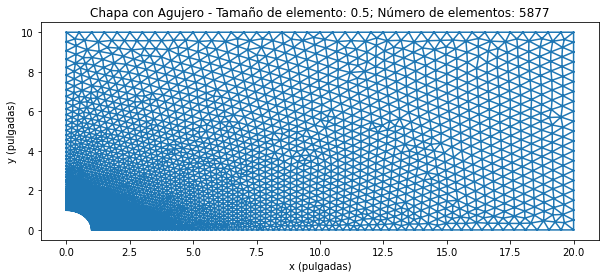

In [10]:
fig, ax = plt.subplots(figsize=(10,4))
plt.title('Chapa con Agujero - '+'Tamaño de elemento: '+str(lc)+'; Número de elementos: '+str(NE))
plt.triplot(MN[:,0], MN[:,1], MC)
plt.ylabel('y (pulgadas)')
plt.xlabel('x (pulgadas)')
print()

In [11]:
GLXN=2
Ee=np.array(NE*[E])
Nue=np.array(NE*[Nu])
te=np.array(NE*[t]) #pulgada
Tension=1000 #psi

In [12]:
Kg, B, D = MisFunciones.k_ensemble2D(MN, MC, Ee, GLXN, Nue, te)

Busco los Nodos de los physical groups para armar las condiciones de contorno. 

In [13]:
NodosTraccionadosTags, NodosTraccionadosCoordFlatten = gmsh.model.mesh.getNodesForPhysicalGroup(1, Traccionado_PG)
NodosEmpotradoXTags, NodosEmpotradoXCoordFlatten = gmsh.model.mesh.getNodesForPhysicalGroup(1, EmpotradoX_PG)
NodosEmpotradoYTags, NodosEmpotradoYCoordFlatten = gmsh.model.mesh.getNodesForPhysicalGroup(1, EmpotradoY_PG)

Defino las r, s, Us y Fr a partir de los nodos de los physical groups


In [14]:
sEmpotradoX=(NodosEmpotradoXTags-1)*GLXN
sEmpotradoY=(NodosEmpotradoYTags-1)*GLXN+1
UsEmpotradoX=np.zeros_like(NodosEmpotradoXTags)
UsEmpotradoY=np.zeros_like(NodosEmpotradoYTags)
gmsh.model.mesh.generate(2) #2 es la dimension

Fijo el punto p1 que use para armar la circunferencia


In [15]:
#NodesInfo[0][0] tiene el tag de p1, le resto 1 para numeracion python
sp1=np.array([(NodeInfo[0][0]-1)*GLXN, (NodeInfo[0][0]-1)*GLXN+1])
Usp1=np.zeros_like(sp1)

In [16]:
s=np.concatenate([sEmpotradoX,sEmpotradoY,sp1]).astype(int)
Us=np.concatenate([UsEmpotradoX,UsEmpotradoY,Usp1]).astype(int)

In [17]:
r=np.array([i for i in range(NumeroNodos*GLXN) if i not in s]).astype(int)

Busco la Matriz de conectividad de los elementos que estan siendo traccionados pra distribuir la fuerza en toda la linea

In [18]:
EntidadTraccionado=gmsh.model.getEntitiesForPhysicalGroup(1,Traccionado_PG)
ETypesTraccionado, ETagsTraccionado, NodeTagsTraccionado = gmsh.model.mesh.getElements(1,EntidadTraccionado[0]) 
NElementosTraccionados=len(ETagsTraccionado[0])
MCTraccionados=NodeTagsTraccionado[0].reshape(NElementosTraccionados,GLXN)-1

In [19]:
Fr=np.zeros_like(r)

for eT in range (NElementosTraccionados):
    n1=MCTraccionados[eT,0].astype(int)
    n2=MCTraccionados[eT,1].astype(int)
    L=abs(MN[n2,1]-MN[n1,1])
    Fr[np.where(r == n1*2)[0][0]] += Tension*L*t/2
    Fr[np.where(r == n2*2)[0][0]] += Tension*L*t/2

In [20]:
U,F = MisFunciones.solve(Kg,s,r,Us,Fr)

In [21]:
sig = {}
d = {}
for e in range(NE):
    nodo = MC[e,:].astype(int)
    d[e] = np.array([U[nodo[0]*GLXN],U[nodo[0]*GLXN+1],
                     U[nodo[1]*GLXN],U[nodo[1]*GLXN+1],
                     U[nodo[2]*GLXN],U[nodo[2]*GLXN+1]]).reshape([-1,1])
    sig[e] = D[e].dot(B[e].dot(d[e]))

In [22]:
U2D = U.reshape(NumeroNodos,GLXN) 
U3D = np.append(U2D,np.zeros(U2D.shape[0]).reshape([-1,1]),1)

In [23]:
MNdef = MN + U3D*1e4  # Le sumo a la chapa inicial, las deformaciones calculadas y se exageran para verlo bien 

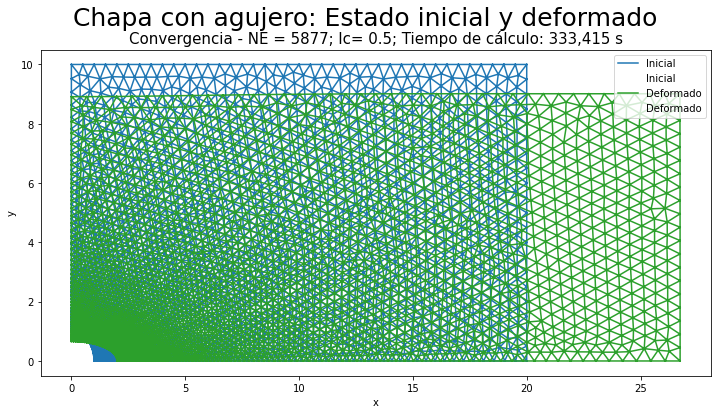

<Figure size 432x288 with 0 Axes>

In [24]:
fig, ax = plt.subplots(figsize=(12,6))
ax.triplot(MN[:,0], MN[:,1], MC, label='Inicial')  # triplot = grafica triangulitos
ax.triplot(MNdef[:,0], MNdef[:,1], MC, label='Deformado')
plt.legend()
plt.suptitle('Chapa con agujero: Estado inicial y deformado',fontsize=25)
plt.title('Convergencia - NE = '+str(NE)+'; lc= '+str(lc)+'; Tiempo de cálculo: 333,415 s',fontsize=15)
plt.xlabel('x')
plt.ylabel('y')
plt.show()
plt.savefig('lc ='+str(lc),format='png')

In [25]:
strains = gmsh.view.add("Desplazamientos")
# por algun motivo le faltaba sumar 1 a nodeinfo
strain_model_data = gmsh.view.addModelData(strains, 0, 'Chapa con agujero', 'NodeData', NodeInfo[0]+1, U3D, numComponents=3)
gmsh.option.setNumber(f'View[{strains}].VectorType',5)

F2D = F.reshape(NumeroNodos,GLXN)
F3D = np.append(F2D,np.zeros(F2D.shape[0]).reshape([-1,1]),1)

forces = gmsh.view.add('forces')
# por algun motivo le faltaba sumar 1 a nodeinfo
forces_model_data = gmsh.view.addModelData(forces, 0, 'Chapa con agujero','NodeData',NodeInfo[0]+1, F3D, numComponents=3)
gmsh.option.setNumber(f'View[{forces}].VectorType',4)
gmsh.option.setNumber(f'View[{forces}].GlyphLocation',2)

sig_xytau = np.hstack(list(sig.values()))  # saco las tensiones del diccionario, quedan en filas para cada elemento las tensiones x, y, xy

sigx = gmsh.view.add('Tensiones en x')
sigy = gmsh.view.add('Tensiones en y')
sigxy = gmsh.view.add('Tensiones xy')


SIGX = gmsh.view.addModelData(sigx, 0, 'Chapa con agujero', 'ElementData', TagsElementos, sig_xytau[0,:].reshape([-1,1]), numComponents=1) # hago reshape porque tienen que ir vectores columnas
SIGY = gmsh.view.addModelData(sigy, 0, 'Chapa con agujero', 'ElementData', TagsElementos, sig_xytau[1,:].reshape([-1,1]), numComponents=1)

end = time.time()

tcalculo=end-start
print(tcalculo)

25.996546745300293


Para estudiar la convergencia, se ve en los siguientes gráficos como al refinar el mallado, aumenta el número de elementos y tambien el tiempo de cálculo. Para lc<0.3 no pude correr el programa. Para lc<0.5 ya no tiene sentido mallar tan fino, la variación del mallado no se justifica para este problema con el tiempo de cálculo.

<img src="lc=5.png">

<img src="lc=3.png">

<img src="lc=2.png">

<img src="lc=1.png">

<img src="lc=0,5.png">

<img src="lc=0,3.png">

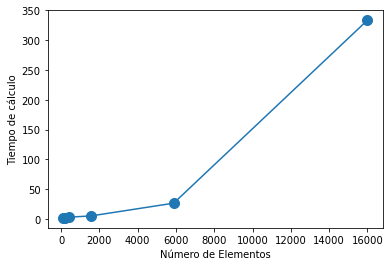

In [26]:
NeTc=np.array([[98,1.677],[222,2.315],[428,3.004],[1541,4.935],[5877,26.415],[15998,333.45]])
x=NeTc[:,0]
y=NeTc[:,1]
plt.plot(x,y,'o-',markersize=10)
plt.xlabel('Número de Elementos')
plt.ylabel('Tiempo de cálculo')
plt.show()


# Problema 2

Calcule las frecuencias naturales de oscilación transversal de una barra de acero (densidad 7850 kg/m^3 y módulo de elasticidad E=210 GPa), de 1 m de longitud, 10 cm² de área, momento de inercia de 10cm^4.Realice el cálculo para un número variable de elementos y estudie la convergencia de sus resultados. Haga el cálculo para matrices de masa concentrada y consistente. Grafique los desplazamientos en función de la posición para los primeros modos normales.

<center><img src="Enunciado 2-2.png"></center>

In [27]:
rho=7850 #kg/m^3
E=210e9 #Pa
LTotal=1 #m
A=10e-4 #m²
I=10e-8 #m^4

In [28]:
NE=50
NN=NE+1
dL=LTotal/NE
GLXN=2
NNXE=2
MC=np.zeros([NE,GLXN])
MN=np.zeros([NN,1])
for i in range (NE): #Armo MC concatenando los elementos contiguos
    MC[i,:]=[i,i+1]
for i in range (NN): #Armo MN considerando que las coord x de cada nodo de cada elemento es la anterior mas dL
    MN[i,:]=i*dL
Eel=np.array(NE*[E])
Ael=np.array(NE*[A])


In [29]:
Ke =(E*I/dL**3)*np.array([[12, 6 * dL, -12, 6 * dL],
						  [6 * dL, 4 * (dL ** 2), -6 * dL, 2 * (dL ** 2)],
						  [-12, -6 * dL, 12, -6 * dL],
						  [6 * dL, 2 * (dL ** 2), -6 * dL, 4 * (dL ** 2)]]) 

In [30]:
Kg=MisFunciones.KGlobal_Barra(MN, MC, GLXN, Ke)

In [31]:
#Matriz consistente, no es diagonal:
Me_Consistente = (rho*A*dL/420)*np.array([[156,   22*dL,     54,   -13*dL],
                         [22*dL,  4*dL**2,   13*dL, -3*dL**2],
                         [54,    13*dL,     156,  -22*dL],
                         [-13*dL, -3*dL**2, -22*dL,  4*dL**2]])

In [32]:
Mg_Consistente=MisFunciones.KGlobal_Barra(MN,MC,GLXN,Me_Consistente)

In [33]:
s=np.array([0,1]) #El nodo 0 no se mueve en y (1)
r=np.array([i for i in range(NN*GLXN) if i not in s]).astype(int)

In [34]:
Us=np.zeros_like(s)


In [35]:
#Despejo omega² para los r:
idxs=np.ix_(r,r)
Omega2_1,u1=linalg.eigh(Kg[idxs],Mg_Consistente[idxs])
f1=np.sqrt(Omega2_1)/(2*np.pi)
uTot1=np.vstack([np.zeros((len(s),len(Omega2_1))),u1])

In [36]:
d1=uTot1[0::2,:] #Agarro las filas de 2 en 2, las pares contienen las d los otros los angulos
d1=d1/d1[-1,:] #Dividis por la última fila porque contiene el desplazamiento mayor creo, no?

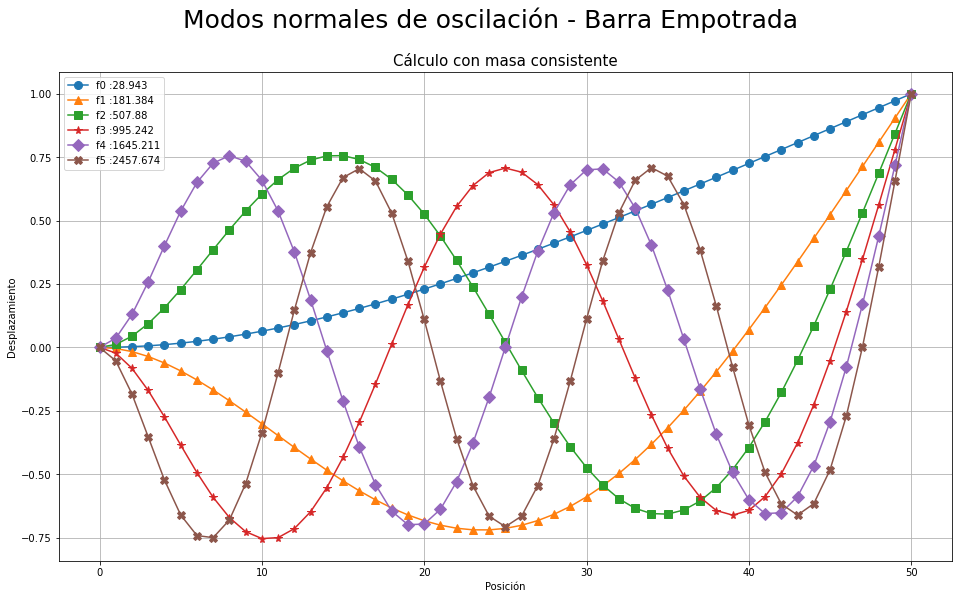

In [37]:
fig=plt.figure(figsize=(16,9))
Markers = ["o", "^", "s", "*", "D", "X"]
for i in range(6):
    plt.plot(np.arange(NN),d1[:,i],markersize=8,label='f'+str(i)+' :'+str(round(f1[i],3)), marker=Markers[i])
plt.title('Cálculo con masa consistente',fontsize=15)
plt.suptitle('Modos normales de oscilación - Barra Empotrada',fontsize=25)
plt.xlabel('Posición')
plt.ylabel('Desplazamiento')
plt.grid()
plt.legend()

In [38]:
Me_Concentrada=(rho*A*dL/24)*np.array([[12,0,0,0],[0,dL**2,0,0],[0,0,12,0],[0,0,0,dL**2]])

In [39]:
Mg_Concentrada=MisFunciones.KGlobal_Barra(MN,MC,GLXN,Me_Concentrada)

In [40]:
Omega2_2,u2=linalg.eigh(Kg[idxs],Mg_Concentrada[idxs])
f2=np.sqrt(Omega2_2)/(2*np.pi)
uTot2=np.vstack([np.zeros((len(s),len(Omega2_2))),u2])

In [41]:
d2=uTot2[0::2,:] 
d2=d2/d2[-1,:]

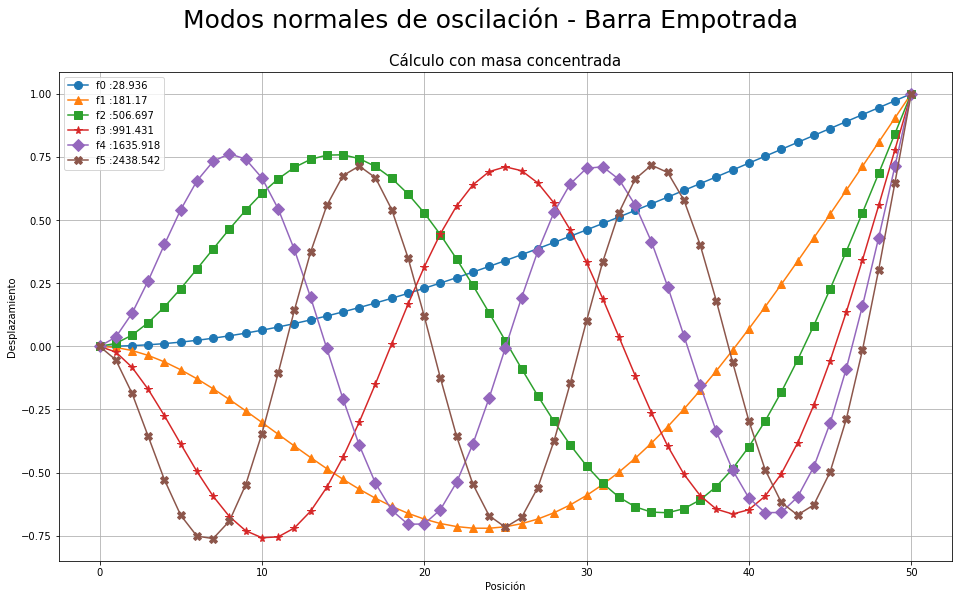

In [42]:
fig=plt.figure(figsize=(16,9))
for i in range(6):
    plt.plot(np.arange(NN),d2[:,i],markersize=8,label='f'+str(i)+' :'+str(round(f2[i],3)), marker=Markers[i])
plt.title('Cálculo con masa concentrada',fontsize=15)
plt.suptitle('Modos normales de oscilación - Barra Empotrada',fontsize=25)
plt.xlabel('Posición')
plt.ylabel('Desplazamiento')
plt.grid()
plt.legend()